In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

project_path = '/content/drive/MyDrive/quora_spam_project'
os.listdir(project_path)


['train.csv', 'glove.6B.100d.txt']

In [ ]:
import pandas as pd

df = pd.read_csv(f'{project_path}/train.csv')
df.head()


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [ ]:
df['target'].value_counts()


,count
target,
0,1225312
1,80810


In [ ]:
import re
import numpy as np

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
    # Lowercase
    text = text.lower()
    return text

df['question_text'] = df['question_text'].astype(str).apply(clean_text)
df.head()


,qid,question_text,target
0,00002165364db923c7e6,how did quebec nationalists see their province...,0
1,000032939017120e6e44,do you have an adopted dog how would you encou...,0
2,0000412ca6e4628ce2cf,why does velocity affect time does velocity af...,0
3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0
4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define how many unique words to keep (only the most common ones)
MAX_VOCAB_SIZE = 20000  # can be 10000 or 30000 too

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['question_text'])

# Turn text into sequences of integers
sequences = tokenizer.texts_to_sequences(df['question_text'])

# Check an example
print("Sample cleaned question:\n", df['question_text'].iloc[0])
print("Tokenized sequence:\n", sequences[0])


Sample cleaned question:
 how did quebec nationalists see their province as a nation in the 1960s
Tokenized sequence:
 [9, 48, 6626, 7331, 155, 55, 6141, 36, 4, 1189, 6, 1, 7185]


In [ ]:
MAX_SEQUENCE_LENGTH = 100  # You can try 150 or 200 too

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = df['target'].values

print("Padded input shape:", X.shape)


Padded input shape: (1306122, 100)


In [ ]:
embedding_index = {}

with open(f"{project_path}/glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f'Total words in GloVe: {len(embedding_index)}')


Total words in GloVe: 400000


In [ ]:
EMBEDDING_DIM = 100

word_index = tokenizer.word_index
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (20000, 100)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

# 1. Embedding Layer (using GloVe weights)
model.add(Embedding(input_dim=num_words,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))  # Set False to freeze GloVe weights

# 2. LSTM Layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# 3. Output Layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# 4. Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=num_words,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    trainable=False))

# LSTM layer
model.add(LSTM(64))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# 💡 Build the model manually (with input shape)
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Show the summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,042,305 (7.79 MB)

 Trainable params: 42,305 (165.25 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=3,
                    batch_size=256)


Epoch 1/3
4082/4082 ━━━━━━━━━━━━━━━━━━━━ 1338s 327ms/step - accuracy: 0.9465 - loss: 0.1489 - val_accuracy: 0.9539 - val_loss: 0.1188
Epoch 2/3
4082/4082 ━━━━━━━━━━━━━━━━━━━━ 1312s 320ms/step - accuracy: 0.9537 - loss: 0.1187 - val_accuracy: 0.9552 - val_loss: 0.1156
Epoch 3/3
4082/4082 ━━━━━━━━━━━━━━━━━━━━ 1302s 319ms/step - accuracy: 0.9556 - loss: 0.1138 - val_accuracy: 0.9569 - val_loss: 0.1111


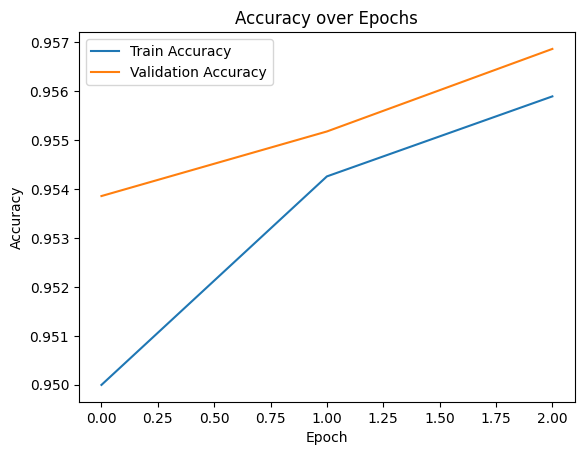

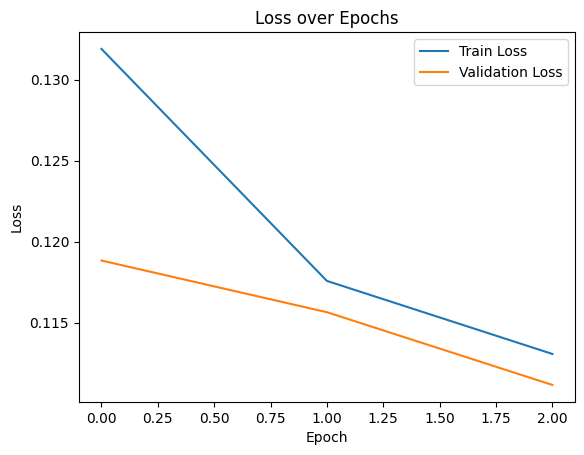

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save(f"{project_path}/quora_spam_model.keras")
print("Model saved successfully!")


Model saved successfully!


In [25]:
from google.colab import files

# Download model
files.download(f"{project_path}/quora_spam_model.keras")

# Download notebook manually: File > Download .ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>